## Explore zero rows

In [65]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [66]:
# Load data
file = "./data/scapegoats.csv"
df = pd.read_csv(file)


In [67]:
df.columns	

Index(['id', 'city', 'postal_code', 'district', 'province', 'price', 'subtype',
       'state_construction', 'living_area', 'terrace_area', 'garden_area',
       'rooms', 'bedrooms', 'bathrooms', 'livingroom_surface',
       'kitchen_surface', 'facades', 'has_garden', 'kitchen', 'furnished',
       'fireplace', 'swimmingpool', 'has_terrace', 'has_attic', 'has_basement',
       'construction_year', 'epc', 'heating', 'area_total'],
      dtype='object')

In [68]:
def IQR(column) -> float:
    """Compute lowerlimit and upperlimit to trim outliers via Tukey's fence"""
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    # quartiles = df[column].quantile([0.25, 0.75])
    iqr = Q3 - Q1
    lowerlimit = Q1 - 1.5 * iqr
    upperlimit = Q3 + 1.5 * iqr

    return lowerlimit, upperlimit

In [69]:
# Cleans price outliers
# Excludes biddings (per immoweb exploration min price of houses is 40k)
mask_price = df["price"] > 40000
df = df[mask_price]

# Cleans the price outliers via IQR function
lowerlimit, upperlimit = IQR(df["price"])
df = df[df["price"].between(lowerlimit, upperlimit)]


# Cleans total_area outliers
# Excludes small properties that are garages under wrong input on immoweb
mask_total_area = df["area_total"] > 50
df = df[mask_total_area]

# Excludes per IQR
lowerlimit_tarea, upperlimit_tarea = IQR(df["area_total"])
df = df[df["area_total"].between(lowerlimit_tarea, upperlimit_tarea)]

# Cleaning living_area outliers
# Excludes again garages and wrong inputs that fall under living_area
mask_living = df["living_area"] > 50
df = df[mask_living]

# Exclude outliers per IQR
lowerlimit_larea, upperlimit_larea = IQR(df["living_area"])
df = df[df["living_area"].between(lowerlimit_larea, upperlimit_larea)]

In [70]:
df.shape

(25675, 29)

In [71]:
df.province.value_counts()

province
East Flanders      4552
Antwerp            3897
West Flanders      3540
Hainaut            3449
Flemish Brabant    2841
Liège              2551
Limburg            1223
Walloon Brabant    1096
Namur              1093
Luxembourg          786
Brussels            647
Name: count, dtype: int64

In [72]:
df.replace("", np.nan, inplace=True)
print(f"After dropping outliers: {df.shape[0]}")
# SELECT ONLY HOUSES
mask_houses = df["subtype"] == "HOUSE"
df= df[mask_houses]

# DROP columns that don't matter for analysis
# Heating is too incomplete. It has only gas, doesn't shoe electrical for example
df.drop(["id","subtype", "heating"], axis=1, inplace=True)
# Better location predictior is district, other locations are too many or too little
df.drop(["city", "postal_code", "province"], axis=1, inplace=True)
# has_terrace has less missing values than area, same as has_garden(to think)
df.drop(["terrace_area", "garden_area"], axis=1, inplace=True)
# Rooms (72% missing) is covered by bathrooms and bedrooms numbers which are more complete 
df.drop(["rooms"], axis=1, inplace=True)
# Furnished, swimmingpool, fireplace are almost all 0. Too uneven distribution for categorical data.
# And have very low correlation with the price
df.drop(['furnished','fireplace', 'swimmingpool'], axis=1, inplace=True)

print(f"After dropping columns and getting only houses: {df.shape[0]}")
# DROP rows where bathroom or bedroom is zero or NaN, because they are a little % of the database
df = df[df.bedrooms != 0]
df = df[df.bathrooms != 0]
df.dropna(subset = ['bedrooms', 'bathrooms'], inplace= True)
print(f"After dropping bathroom and bedrooms that are not 0 or null: {df.shape[0]}")

# TO DO IF FACADES BIGGER ThAN, its 4
# Drop houses with more than 4 facades, because thats weird
facade_mask = df["facades"] > 4
df.loc[facade_mask, 'facades'] = 4

print(f"After dropping weird facades: {df.shape[0]}")
# Selecting only columns with EPC correctly inputed, maybe think about this more
# TO DO PUT AS NAN THE ONES THat ARE NOT WELL INPUTED
# BEAR IDEA MAKE EPC VALUE NUMERICAL?????
mask_epc = df["epc"].isin(["A++", "A+", "A", "B", "C", "D", "E", "F", "G"])
df.loc[~mask_epc, 'epc'] = np.nan
print(f"After dropping wrong EPC: {df.shape[0]}")
# Group EPCS A
group_epc = {"A++": 6, 
             "A+": 6, 
             "A": 6,
             "B":5,
             "C":4,
             "D":3,
             "E":2,
             "F":1,
             "G": 0
            }
df = df.replace({"epc": group_epc})


# Group state of construction:

mask_state = df["state_construction"].isin(["GOOD", "JUST_RENOVATED", "AS_NEW", "TO_RENOVATE", "AS_NEW","TO_RESTORE","TO_BE_DONE_UP"])
df.loc[~mask_state, 'state_construction'] = np.nan
# Drop rows where kitchen or livingroom area is bigger than living area
mask_kitchen = df["kitchen_surface"] > df["living_area"]
mask_living = df["livingroom_surface"] > df["living_area"]
df = df[~mask_kitchen]
df = df[~mask_living]

print(f"After dropping kitchen and livingr bigger than living area: {df.shape[0]}")

# Substitute living area, terrace area and kitchen surface that are too small for NaN
df.loc[df.livingroom_surface <5 , 'livingroom_surface'] = np.nan
df.loc[df.kitchen_surface <5 , 'kitchen_surface'] = np.nan

# substitute NaN for 0 in some columns assuming no imput means it doesn't have
df["has_terrace"] = df["has_terrace"].fillna(0)
df["has_basement"] = df["has_basement"].fillna(0)
df["has_attic"] = df["has_attic"].fillna(0)
df["has_garden"] = df["has_garden"].fillna(0)


# Clean rows where living_area is bigger than total_area
# I made a study to see how this affects the data, and doesn't mess with the price distribution
mask_difference_areas= df["area_total"] > df["living_area"]
df = df[mask_difference_areas]
print(f"After dropping tota area less than living: {df.shape[0]}")

df.drop_duplicates(inplace=True)

After dropping outliers: 25675
After dropping columns and getting only houses: 21895
After dropping bathroom and bedrooms that are not 0 or null: 19819
After dropping weird facades: 19819
After dropping wrong EPC: 19819
After dropping kitchen and livingr bigger than living area: 19795
After dropping tota area less than living: 16328


C:\Users\t_dei\AppData\Local\Temp\ipykernel_16096\555762110.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"epc": group_epc})
C:\Users\t_dei\AppData\Local\Temp\ipykernel_16096\555762110.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~mask_living]


In [73]:
# Seeing missing values
percent_missing = df.isnull().sum()/ len(df)
percent_missing

district              0.000000
price                 0.000000
state_construction    0.253930
living_area           0.000000
bedrooms              0.000000
bathrooms             0.000000
livingroom_surface    0.550937
kitchen_surface       0.581876
facades               0.209785
has_garden            0.000000
kitchen               0.000000
has_terrace           0.000000
has_attic             0.000000
has_basement          0.000000
construction_year     0.404226
epc                   0.215382
area_total            0.000000
dtype: float64

In [74]:
# Measure 0 per column
print(df[df == 0].count(axis=0)/len(df.index))

district              0.000000
price                 0.000000
state_construction    0.000000
living_area           0.000000
bedrooms              0.000000
bathrooms             0.000000
livingroom_surface    0.000000
kitchen_surface       0.000000
facades               0.000000
has_garden            0.602503
kitchen               0.392592
has_terrace           0.484970
has_attic             0.683247
has_basement          0.626085
construction_year     0.000000
epc                   0.053955
area_total            0.000000
dtype: float64


In [75]:
# Force dtypes that make sense

convert_dict = {'bathrooms': 'Int64',
                "facades": 'Int64',
                'has_garden': 'Int64',
                "has_terrace": 'Int64',
                'has_attic': 'Int64',
                "has_basement": 'Int64',
                "construction_year": 'Int64',
                "epc":'Int64'
                }
 
df = df.astype(convert_dict)

In [76]:
df.describe()

,price,living_area,bedrooms,bathrooms,livingroom_surface,kitchen_surface,facades,has_garden,kitchen,has_terrace,has_attic,has_basement,construction_year,epc,area_total
count,15902.000000,15902.000000,15902.000000,15902.0,7141.000000,6649.000000,12566.0,15902.0,15902.000000,15902.0,15902.0,15902.0,9474.0,12477.0,15902.000000
mean,358314.561313,172.131116,3.255943,1.187712,32.622322,14.398105,3.017189,0.397497,0.607408,0.51503,0.316753,0.373915,1971.762613,2.891961,576.325053
std,150935.485133,49.717204,0.876512,0.467192,12.190944,6.943788,0.775587,0.489396,0.488343,0.49979,0.465225,0.483857,40.401248,1.780122,386.547680
min,45000.000000,51.000000,1.000000,1.0,6.000000,5.000000,1.0,0.0,0.000000,0.0,0.0,0.0,1764.0,0.0,60.000000
25%,249000.000000,138.000000,3.000000,1.0,25.000000,10.000000,2.0,0.0,0.000000,0.0,0.0,0.0,1950.0,1.0,282.000000
50%,345000.000000,166.000000,3.000000,1.0,32.000000,13.000000,3.0,0.0,1.000000,1.0,0.0,0.0,1970.0,3.0,461.000000
75%,449000.000000,200.000000,4.000000,1.0,39.000000,17.000000,4.0,1.0,1.000000,1.0,1.0,1.0,2010.0,4.0,770.000000
max,890500.000000,330.000000,10.000000,15.0,186.000000,146.000000,4.0,1.0,1.000000,1.0,1.0,1.0,2025.0,6.0,1897.000000


In [77]:
df = df.sort_values(by=['price'])
df = df.reset_index(drop=True)
df

,district,price,state_construction,living_area,bedrooms,bathrooms,livingroom_surface,kitchen_surface,facades,has_garden,kitchen,has_terrace,has_attic,has_basement,construction_year,epc,area_total
0,Charleroi,45000.0,NaN,150.0,3,1,35.0,NaN,3,0,1,1,0,0,<NA>,2,297
1,Charleroi,45000.0,TO_RENOVATE,60.0,2,1,17.0,16.0,3,0,0,1,0,1,<NA>,<NA>,70
2,Mons,45000.0,TO_RESTORE,121.0,3,1,NaN,NaN,3,0,0,1,0,1,<NA>,0,180
3,Mons,49000.0,TO_RENOVATE,65.0,1,1,NaN,11.0,4,0,0,0,1,1,<NA>,0,916
4,Philippeville,49000.0,TO_RESTORE,99.0,4,1,30.0,NaN,2,0,1,1,1,1,<NA>,0,238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,Antwerp,885000.0,NaN,193.0,4,2,NaN,NaN,3,0,1,0,0,1,1902,3,604
15898,Brugge,886129.0,GOOD,163.0,3,1,NaN,NaN,<NA>,0,1,0,0,0,<NA>,<NA>,1178
15899,Veurne,886129.0,GOOD,163.0,3,1,NaN,NaN,<NA>,0,1,0,0,0,<NA>,<NA>,635
15900,Brussels,890000.0,AS_NEW,240.0,4,3,22.0,10.0,3,1,1,1,1,0,1999,3,260


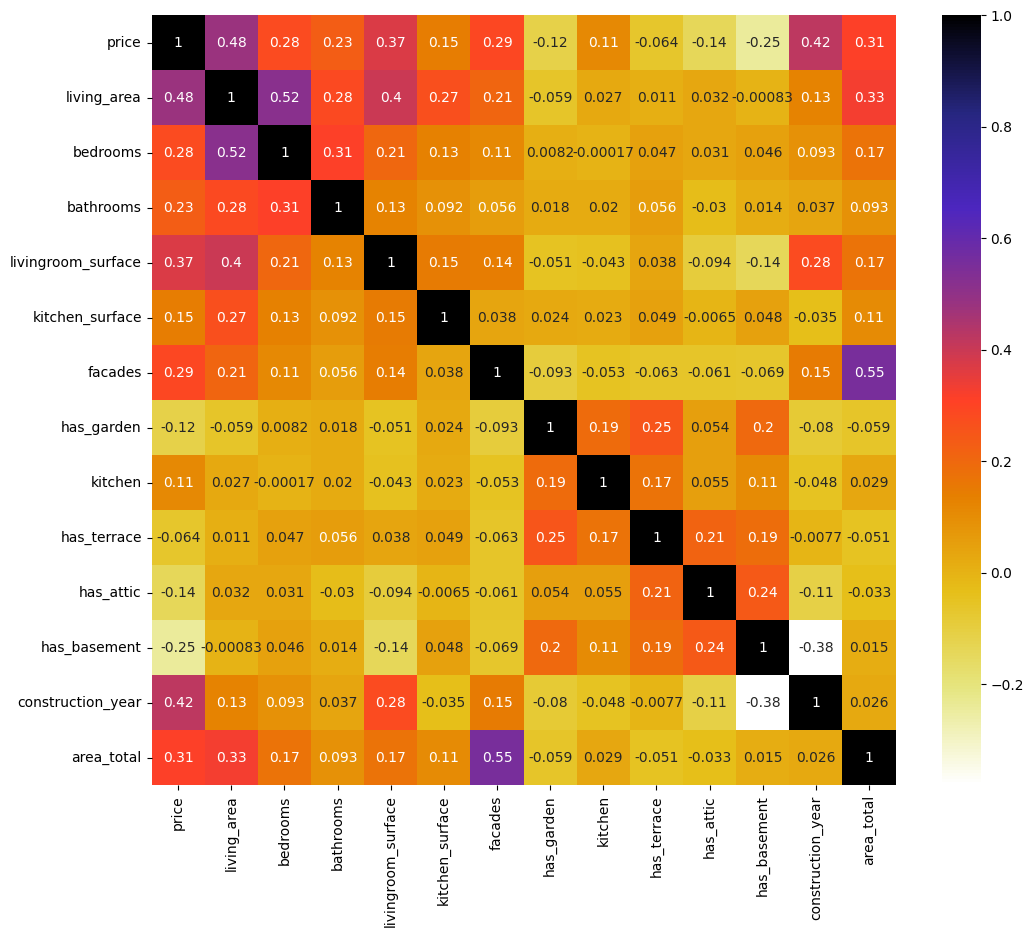

In [78]:
cor = df[['price','living_area', 'bedrooms',
       'bathrooms', 'livingroom_surface', 'kitchen_surface', 'facades',
       'has_garden', 'kitchen', 'has_terrace', 'has_attic', 'has_basement',
       'construction_year','area_total']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
plt.show()  

In [79]:
df.to_csv("cleaned_houses.csv", index=False)

In [80]:
df.dtypes

district               object
price                 float64
state_construction     object
living_area           float64
bedrooms                int64
bathrooms               Int64
livingroom_surface    float64
kitchen_surface       float64
facades                 Int64
has_garden              Int64
kitchen                 int64
has_terrace             Int64
has_attic               Int64
has_basement            Int64
construction_year       Int64
epc                     Int64
area_total              int64
dtype: object